In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.sparse.linalg import eigs
from scipy.integrate import solve_ivp, solve_bvp, odeint
from scipy.special import eval_hermite

# AMATH 581 Homework 3
## Eric Leonard, ericcl@uw.edu

## Problem 1 (continue'd from Homework 2)
The probability density evolution in a one-dimensional harmonic trapping potential is governed by the partial
differential equation:

$$i\hbar\psi_t + \frac{\hbar^2}{2m}\psi_{xx} − V(x)\psi = 0$$

where $\psi$ is the probability density and $V(x) = kx^2 / 2$ is the harmonic confining potential. A typical solution
technique for this problem is to assume a solution of the form

$$\psi = \sum_1^N a_n\phi_n(x)\exp{\left(−i\frac{E_n}{2\hbar}t\right)}$$

which is called an eigenfunction expansion solution ($\phi_n$ = eigenfunction, $E_n$ = eigenvalue). Plugging in this
solution ansatz to Eq. (1) gives the boundary value problem:

$$\frac{d^2\phi_n}{dx^2} − \left[Kx^2 − \varepsilon_n\right]\phi_n = 0$$

where we expect the solution $\phi_n(x) \to 0$ as $x \to \pm\infty$ and $\varepsilon_n$ is the quantum energy. Note here that $K = km/\hbar^2$
and $\varepsilon_n = E_n m/\hbar^2$. In what follows, take $K = 1$ and always normalize so that $\int_{-\infty}^\infty |\phi_n|^2dx = 1$.

**(a)** Rerun your homework 2 results to produce the eigenfunctions (A1) and eigenvalues (A2)

**ANSWERS**: Should be written out as A1 (eigenfunctions) and A2 (eigenvalues)

In [2]:
# Constants
K = 1  # given constant
L = 4  # boundary
x_span = np.arange(-L, L + 0.1, 0.1)  # Discretized space for x in [-L, L]
tol = 1e-4  # tolerance for the shooting method

# The second-order ODE rewritten as a system of first-order ODEs:
# ϕ[0] = ϕ_n(x)
# ϕ[1] = d(ϕ_n)/dx
def harmonic_oscillator_ode(ϕ, x, ϵ):
    return [ϕ[1], (K * x**2 - ϵ) * ϕ[0]]

# Normalization of eigenfunctions
def normalize(ϕ, x_span):
    norm = np.trapz(abs(ϕ)**2, x_span)
    return ϕ / np.sqrt(norm)

# Shooting method to find the eigenvalue epsilon
def shooting_method(ϵ, x_span, n, tol):
    dϵ = ϵ / 10 # used to adjust ϵ
    for i in range(1000): #while True:
        ϕ0 = [1, np.sqrt(K*(L)**2 - ϵ)] # initial conditions
        sol = odeint(harmonic_oscillator_ode, ϕ0, x_span, args=(ϵ,)) # solve system of ODEs 
        ϕ, dϕdx = sol[:, 0], sol[:, 1]
        ϕL, dϕdxL = ϕ[-1], dϕdx[-1]  # Value of ϕ_n(L) (boundary at x = L)

        # Check if the boundary condition is satisfied within the tolerance
        if abs(dϕdxL + np.sqrt(K*(L)**2 - ϵ) * ϕL) < tol:
            return ϵ
        
        # Update epsilon bounds based on the sign of the boundary value
        if (-1)**(n) * (dϕdxL + np.sqrt(K*L**2 - ϵ) * ϕL) > 0:
            ϵ += dϵ
        else:
            ϵ -= dϵ / 2
            dϵ /= 2
    return ϵ
    
# Main function to calculate the first five eigenfunctions and eigenvalues
def find_eigenfunctions(num_eigenfunctions, x_span, tol):
    eigenfunctions = np.zeros((len(x_span), num_eigenfunctions))
    eigenvalues = np.zeros(num_eigenfunctions)
    
    # Initial guesses for eigenvalues
    ϵ0 = [1, 3, 5, 7, 9]
    
    for n in range(num_eigenfunctions):
        ϵn = shooting_method(ϵ0[n], x_span, n, tol)
        ϕ0 = [1, np.sqrt(K*(L)**2 - ϵn)]
        ϕn = odeint(harmonic_oscillator_ode, ϕ0, x_span, args=(ϵn,))[:,0]
        ϕn = normalize(ϕn, x_span)
        
        eigenfunctions[:, n] = np.abs(ϕn) # Store absolute value of eigenfunctions
        eigenvalues[n] = ϵn
    
    return eigenfunctions, eigenvalues

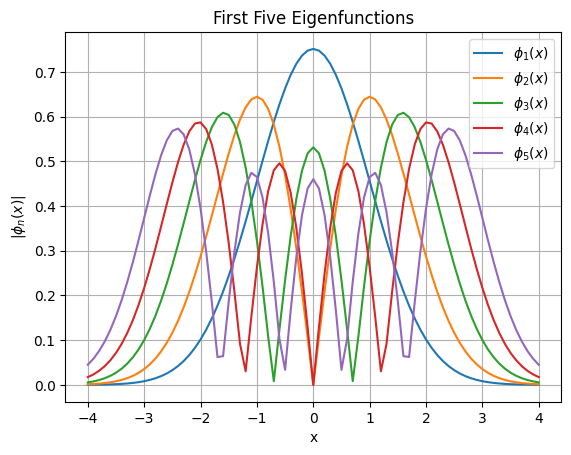

A2 (Eigenvalues):
[0.99999998 2.9999994  4.99998953 6.99988317 8.99906058]


In [3]:
# Calculate the first five eigenfunctions and eigenvalues
eigenfunctions, eigenvalues = find_eigenfunctions(5, x_span, tol)

# Display the results
A1 = eigenfunctions  # Absolute value of eigenfunctions
A2 = eigenvalues    # Eigenvalues

# Plot eigenfunctions
for n in range(5):
    plt.plot(x_span, eigenfunctions[:, n], label=f'$\\phi_{n+1}(x)$')
plt.title('First Five Eigenfunctions')
plt.xlabel('x')
plt.ylabel('$|\\phi_n(x)|$')
plt.legend()
plt.grid(True)
plt.show()

# Output results
print("A2 (Eigenvalues):")
print(A2)

**(b)** Calculate the first five normalized eigenfunctions $(\phi_n)$ and eigenvalues $(\varepsilon_n)$ using a direct method. Be sure to use a forward- and backward-differencing for the boundary conditions (HINT: $3 + 2\Delta x\sqrt{KL^2 − \varepsilon_n} \approx 3$). For this calculation, use $x \in [−L, L]$ with $L = 4$ and choose $x_{span} = −L : 0.1 : L$. Save the absolute value of the eigenfunctions in a 5-column matrix (column 1 is $\phi_1$, column 2 is $\phi_2$ etc.) and the eigenvalues in a 1x5 vector. NOTE: This procedure solves for the *interior* points. So be sure at the end to include your first and last point.

**ANSWERS**: Should be written out as A3 (eigenfunctions) and A4 (eigenvalues)

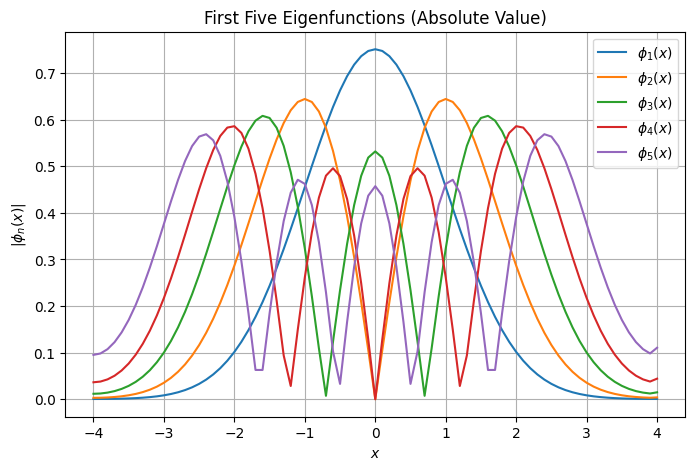

Eigenvalues (A4): [0.99937352 2.996839   4.99140656 6.98038865 8.95060003]


In [4]:
def solve_eigenfunctions_direct(K=1, L=4, dx=0.1, num_eigenvalues=5):
    # Define x grid
    x_span = np.arange(-L, L + dx, dx)
    N = len(x_span)
    x = np.linspace(-L, L, N)
    
    # Set up the tridiagonal matrix for finite difference scheme
    left_bc = np.zeros((N-2,N-2))
    left_bc[0,0] = -4 / (3*dx**2) # use forward difference for left bc
    left_bc[0,1] = 1 / (3*dx**2)

    right_bc = np.zeros((N-2,N-2))
    right_bc[-1,-1] = -4 / (3*dx**2) # use forward difference for left bc
    right_bc[-1,-2] = 1 / (3*dx**2)
    
    diagonal = np.array([-(2 / (dx**2) + (K * xi**2)) for xi in x_span[1:-1]])
    off_diagonal = np.ones(N - 3) / dx**2
    
    # Construct the Hamiltonian matrix using the forward and backward differencing
    H = -(np.diag(diagonal) + np.diag(off_diagonal, 1) + np.diag(off_diagonal, -1)) + right_bc + left_bc

    # Solve for eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(H)
    
    # Select the first `num_eigenvalues` smallest eigenvalues and corresponding eigenvectors
    sort_idx = eigenvalues.argsort()   
    eigenvalues = eigenvalues[sort_idx][:num_eigenvalues]
    eigenfunctions = eigenvectors[:, sort_idx][:, :num_eigenvalues]
    
    ϕ0 = (-4*eigenfunctions[0,:] + eigenfunctions[1,:]) / (-3)
    ϕend = (4*eigenfunctions[-2, :] - eigenfunctions[-1,:]) / (-3)
    ϕn = np.vstack([ϕ0[None, :], eigenfunctions, ϕend[None, :]])
    
    # Normalize eigenfunctions
    for i in range(num_eigenvalues):
        ϕn[:, i] = normalize(ϕn[:, i], x_span)
    
    return np.abs(ϕn), eigenvalues

# Solve for eigenfunctions and eigenvalues
A3, A4 = solve_eigenfunctions_direct()

# Plot the first five eigenfunctions
x_span = np.arange(-4, 4 + 0.1, 0.1)
plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(x_span, A3[:, i], label=f"$\phi_{i+1}(x)$")
plt.xlabel("$x$")
plt.ylabel("$|\phi_n(x)|$")
plt.legend()
plt.title("First Five Eigenfunctions (Absolute Value)")
plt.grid()
plt.show()

# Print the eigenvalues
print("Eigenvalues (A4):", A4)

**(c)** There has been suggestions that in some cases, nonlinearity plays a role such that

$$\frac{d^2\phi_n}{dx^2} − \left[\gamma|\phi_n|^2 + Kx^2 − \varepsilon_n\right]\phi_n = 0.$$

Depending upon the sign of $\gamma$, the probability density is focused or defocused. Find the first two *normalized* modes for $γ = \pm0.05$ using shooting. For this calculation, use $x \in [−L, L]$ with $L = 2$ and choose $x_{span} = −L : 0.1 : L$. Save the absolute value of the eigenfunctions in a 2-column matrix (column 1 is $\phi_1$ and column 2 is $\phi_2$) and the eigenvalues in a 1x2 vector.

**ANSWERS**: For $\gamma = 0.05$, should be written out as A5 (eigenfunctions) and A6 (eigenvalues)

**ANSWERS**: For $\gamma = −0.05$, should be written out as A7 (eigenfunctions) and A8 (eigenvalues)

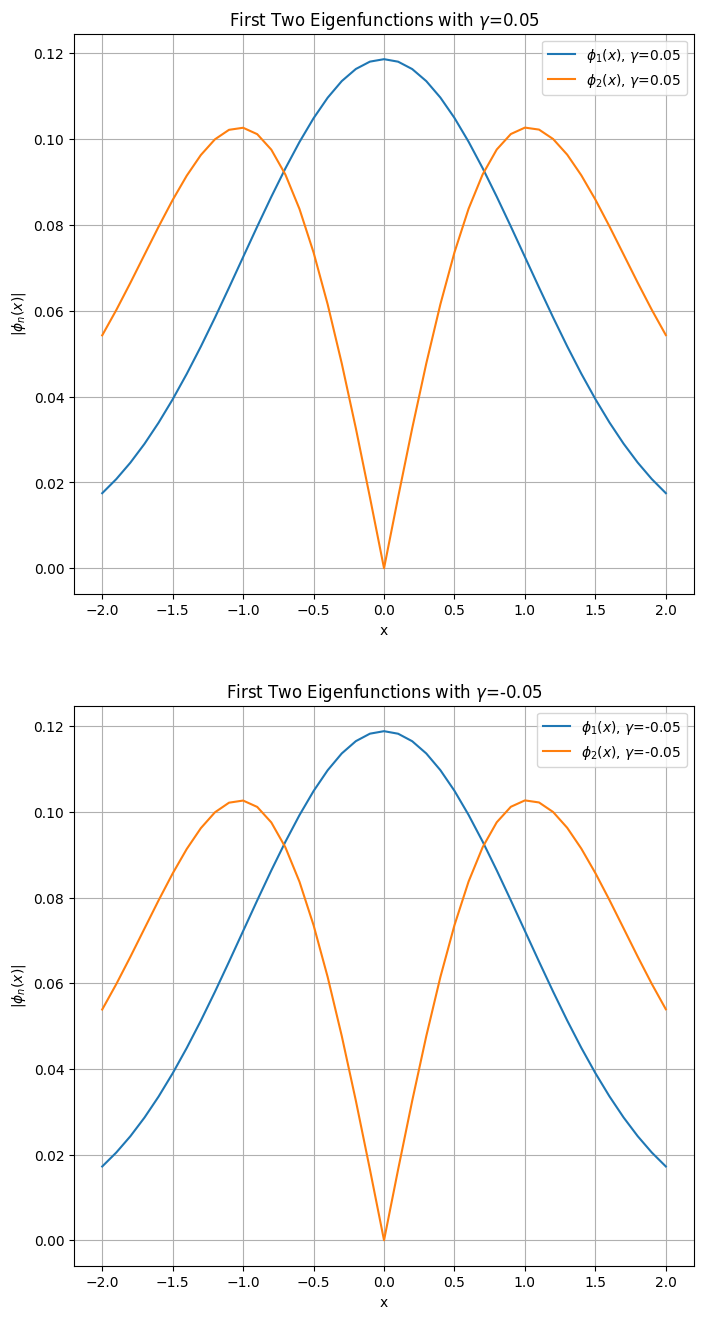

Eigenvalues for gamma = 0.05:
[1.01295239 2.92139785]
Eigenvalues for gamma = -0.05:
[0.97405394 2.89311186]


In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
K = 1  # Given constant for harmonic potential
L = 2  # Boundary for the integration
x_eval = np.arange(-L, L + 0.1, 0.1)  # Points to evaluate solution in x
x_span = (x_eval[0], x_eval[-1])  # Start and end points for x
tol = 1e-4  # Tolerance for the shooting method

# The second-order ODE rewritten as a system of first-order ODEs with nonlinearity:
# ϕ[0] = ϕ_n(x)
# ϕ[1] = d(ϕ_n)/dx
def nonlinear_Schrodinger_system(x, ϕ, ϵ, γ):
    return [ϕ[1], (γ * abs(ϕ[0])**2 + K * x**2 - ϵ) * ϕ[0]]

# Shooting method to find the eigenvalue epsilon
def shooting_method_nonlinear(ϵ, x_span, n, γ, tol):
    A = 0.1
    dA = 0.01
    for _ in range(1000):  # Maximum iterations to avoid infinite loops
        dϵ = ϵ / 10  # Step size for adjusting ϵ
        for __ in range(1000):
            ϕ0 = [A, A * np.sqrt(np.abs(K * L**2 - ϵ))]  # Initial conditions as 1D list
            sol = solve_ivp(nonlinear_Schrodinger_system, x_span, ϕ0, t_eval=x_eval, args=(ϵ, γ))  # Solve system of ODEs
            ϕ, dϕdx = sol.y[0], sol.y[1]  # Use .y attribute to access the solution components
            ϕL, dϕdxL = ϕ[-1], dϕdx[-1]  # Value of ϕ_n(L) and d(ϕ_n)/dx at x = L

            # Check if the boundary condition is satisfied within the tolerance
            if abs(dϕdxL + np.sqrt(K * L**2 - ϵ) * ϕL) < tol:
                break#return ϵ, A
        
            # Update epsilon bounds based on the sign of the boundary value
            if (-1)**n * (dϕdxL + np.sqrt(K * L**2 - ϵ) * ϕL) > 0:
                ϵ += dϵ
            else:
                ϵ -= dϵ / 2
                dϵ /= 2
        if abs(np.trapz(abs(ϕ**2), x_eval) - 1) < tol:
            return ϵ, A
    
            # Update epsilon bounds based on the sign of the boundary value
        if np.trapz(abs(ϕ)**2, x_eval) - 1 < 0:
            A += dA
        else:
            A -= dA / 2
            dA /= 2
    
    return ϵ, A  # Return final epsilon after iterations

# Main function to calculate the first two normalized eigenfunctions and eigenvalues for gamma = ±0.05
def find_nonlinear_eigenfunctions(num_eigenfunctions, x_span, γ, tol):
    eigenfunctions = np.zeros((len(x_eval), num_eigenfunctions))
    eigenvalues = np.zeros(num_eigenfunctions)
    
    # Initial guesses for eigenvalues
    ϵ0 = [1, 3]  # First two eigenvalues, can be adjusted for higher modes
    
    for n in range(num_eigenfunctions):
        ϵn, An = shooting_method_nonlinear(ϵ0[n], x_span, n, γ, tol)
        ϕ0 = [An, An*np.sqrt(K * L**2 - ϵn)]
        sol = solve_ivp(nonlinear_Schrodinger_system, x_span, ϕ0, t_eval=x_eval, args=(ϵn, γ))
        ϕn = sol.y[0,:]  # Extract the eigenfunction solution
        ϕn = normalize(ϕn, x_span)  # Normalize the eigenfunction
        
        eigenfunctions[:, n] = np.abs(ϕn)  # Store absolute value of eigenfunctions
        eigenvalues[n] = ϵn
    
    return eigenfunctions, eigenvalues

# Compute and plot for γ = ±0.05
A5,A6 = find_nonlinear_eigenfunctions(2, x_span, 0.05, tol)
A7,A8 = find_nonlinear_eigenfunctions(2, x_span, -0.05, tol)

fig, axes = plt.subplots(2,1, figsize=(8,16))
# Plot eigenfunctions
for n in range(2):
    axes[0].plot(x_eval, A5[:, n], label=f'$\\phi_{n+1}(x)$, $\\gamma$=0.05')
    axes[0].set_title(f'First Two Eigenfunctions with $\\gamma$=0.05')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('$|\\phi_n(x)|$')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(x_eval, A7[:, n], label=f'$\\phi_{n+1}(x)$, $\\gamma$=-0.05')
    axes[1].set_title(f'First Two Eigenfunctions with $\\gamma$=-0.05')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('$|\\phi_n(x)|$')
    axes[1].legend()
    axes[1].grid(True)
    
plt.show()

# Output eigenvalues
print(f"Eigenvalues for gamma = 0.05:")
print(A6)
print(f"Eigenvalues for gamma = -0.05:")
print(A8)

**(d)** For a fixed value of the energy (specifically, take $\varepsilon_n = 1$, $\gamma = 0$ with $x \in [−L, L]$ and $L = 2$. For initial
launch conditions, take $φ = 1$ and $φ_x = \sqrt{KL^2 − 1}$, do a convergence study by controlling the error tolerance

```python
options = {’rtol’: TOL, ’atol’: TOL}
solve_ivp(hw1_rhs_a, x_span, y0, method=’RK45’, args=(E,), **options)
```

Show that indeed the schemes are fourth order (RK45) and second order (RK23) respectively by running the computation across the computational domain and adjusting the tolerance. Use specifically the following values of 

```python 
TOL = [1e−4, 1e−5, 1e−6, 1e−7, 1e−8, 1e−9, 1e−10].
```

In particular, plot on a log-log scale the average step-size ($x$-axis) using the diff and mean command versus the tolerance ($y$-axis) for the above tolerance values. What are the slopes of these lines? Use the POLYFIT command to get the slopes. Note that the local error should be $O(\Delta t^5)$ and $O(\Delta t^3)$ respectively. What are the local errors for Radau and BDF? Save the slopes computed from the POLYFIT command with the log-log of the data as a 4x1 vector with the slopes of RK45, RK23, Radau and BDF respectively.

**ANSWERS**: Should be written out as A9

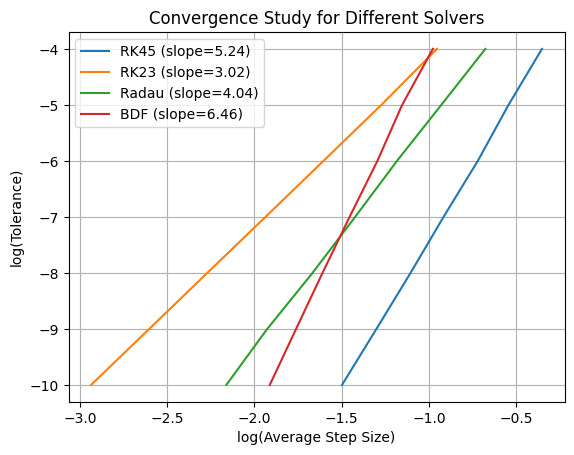

A9 (slopes for RK45, RK23, Radau, BDF): [5.24466756 3.01909953 4.03819927 6.45751261]


In [6]:
# Define constants and initial conditions
K = 1
L = 2
ϵₙ = 1
γ = 0
x_span = [-L, L]
ϕ0 = 1
ϕₓ0 = np.sqrt(K * L**2 - ϵₙ)
y0 = [ϕ0, ϕₓ0]

# Tolerance values for convergence study
TOL = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# Method list for comparison
methods = ['RK45', 'RK23', 'Radau', 'BDF']
slopes = []

# Perform convergence study for each method
for method in methods:
    avg_step_sizes = []
    
    for tol in TOL:
        sol = solve_ivp(nonlinear_Schrodinger_system, x_span, y0, method=method, args=(ϵₙ, 0), rtol=tol, atol=tol)
        
        # Calculate mean step size
        step_sizes = np.diff(sol.t)
        avg_step_sizes.append(np.mean(step_sizes))
    
    # Perform log-log fit and store slope
    log_tolerance = np.log10(TOL)
    log_step_sizes = np.log10(avg_step_sizes)
    slope, _ = np.polyfit(log_step_sizes, log_tolerance, 1)
    slopes.append(slope)

    # Plot each method's log-log graph
    plt.plot(log_step_sizes, log_tolerance, label=f'{method} (slope={slope:.2f})')

# Customize plot
plt.xlabel('log(Average Step Size)')
plt.ylabel('log(Tolerance)')
plt.title('Convergence Study for Different Solvers')
plt.legend()
plt.grid(True)
plt.show()

# Display slopes as A9
A9 = np.array(slopes)
print("A9 (slopes for RK45, RK23, Radau, BDF):", A9)

**(e)** Compare your solutions in both **(a)** and **(b)** of homework 1 with the exact Gauss-Hermite polynomial solutions for this problem (See wikipedia.com, for instance). Compute the error between your numerical solution and the exact solution for the values of the eigenfunctions and eigenvalues computed above. Specifically, calculate the following quantity for each eigenfunction $\| |\phi_n^{numerical}| − |\phi_n^{exact}|\|$ where $\|f(x)\| = \int_{-L}^L f(x)^2dx$. For the eigenvalues, simply calculate the relative percent error $100 \times (|\varepsilon_n^{numerical} − \varepsilon_n^{exact}| / \varepsilon_n^{exact})$. The error vectors associated with the eigenfunctions and eigenvalues should be 5x1 vectors.

**ANSWERS**: For part **(a)**, should be written out as A10 (eigenfunctions) and A11 (eigenvalues)

**ANSWERS**: For part **(b)**, should be written out as A12 (eigenfunctions) and A13 (eigenvalues)

NOTE: For the tolerances in both the convergence (shooting method) of the $\varepsilon_n$ in **(a)** and **(c)**, and in the area for part **(c)**, use a tolerance of $10^{−4}$

In [7]:
# Define constants and interval
L = 4
x_span = np.arange(-L, L + 0.1, 0.1)
K = 1

def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

# Exact Gauss-Hermite solutions
def exact_eigenfunction(n, x):
    """Compute the exact eigenfunction using the n-th Hermite polynomial."""
    normalization_factor = (2**n * factorial(n) * np.sqrt(np.pi))**-0.5
    return normalization_factor * np.exp(-x**2 / 2) * eval_hermite(n, x)

# Exact eigenvalues (analytical values for the quantum harmonic oscillator)
exact_eigenvalues = [2*n + 1 for n in range(5)]

# Numerical solutions from (a) and (b)
# Assume phi_n_numerical_a and phi_n_numerical_b are lists of arrays for the five eigenfunctions
# and epsilon_n_numerical_a and epsilon_n_numerical_b are lists of five computed eigenvalues
# Replace these with actual numerical solution results
ϕₙ_numerical_a = A1  # Insert eigenfunctions from part (a)
ϕₙ_numerical_b = A3  # Insert eigenfunctions from part (b)
ϵₙ_numerical_a = A2  # Insert eigenvalues from part (a)
ϵₙ_numerical_b = A4  # Insert eigenvalues from part (b)

# Tolerance for error calculations
tolerance = 1e-4

# Error vectors
error_eigenfunctions_a = []
error_eigenvalues_a = []
error_eigenfunctions_b = []
error_eigenvalues_b = []

for n in range(5):
    # Compute exact eigenfunction on the grid
    ϕ_exact = exact_eigenfunction(n, x_span)
    ϕ_exact_abs = np.abs(ϕ_exact)

    # Part (a) Eigenfunction Error
    ϕ_num_abs_a = np.abs(ϕₙ_numerical_a[:, n])
    error_integrand_a = (ϕ_num_abs_a - ϕ_exact_abs) ** 2
    error_norm_a = np.trapz(error_integrand_a, x_span)
    error_eigenfunctions_a.append(error_norm_a)

    # Part (a) Eigenvalue Error
    ϵ_exact = exact_eigenvalues[n]
    ϵ_num_a = ϵₙ_numerical_a[n]
    relative_error_eigenvalue_a = 100 * abs(ϵ_num_a - ϵ_exact) / ϵ_exact
    error_eigenvalues_a.append(relative_error_eigenvalue_a)

    # Part (b) Eigenfunction Error
    ϕ_num_abs_b = np.abs(ϕₙ_numerical_b[:, n])
    error_integrand_b = (ϕ_num_abs_b - ϕ_exact_abs) ** 2
    error_norm_b = np.trapz(error_integrand_b, x_span)
    error_eigenfunctions_b.append(error_norm_b)

    # Part (b) Eigenvalue Error
    ϵ_num_b = ϵₙ_numerical_b[n]
    relative_error_eigenvalue_b = 100 * abs(ϵ_num_b - ϵ_exact) / ϵ_exact
    error_eigenvalues_b.append(relative_error_eigenvalue_b)

# Convert lists to numpy arrays for the final output
A10 = np.array(error_eigenfunctions_a)
A11 = np.array(error_eigenvalues_a)
A12 = np.array(error_eigenfunctions_b)
A13 = np.array(error_eigenvalues_b)

# Output results
print("A10 (Eigenfunction errors for part (a)):", A10)
print("A11 (Eigenvalue errors for part (a)):", A11)
print("A12 (Eigenfunction errors for part (b)):", A12)
print("A13 (Eigenvalue errors for part (b)):", A13)

A10 (Eigenfunction errors for part (a)): [5.18231988e-12 2.73795165e-10 7.48972057e-09 1.45930842e-07
 2.31588312e-06]
A11 (Eigenvalue errors for part (a)): [2.32248567e-06 1.99303031e-05 2.09361315e-04 1.66893005e-03
 1.04379654e-02]
A12 (Eigenfunction errors for part (b)): [2.41418676e-07 2.59562562e-06 2.05586571e-05 1.71300106e-04
 1.33439719e-03]
A13 (Eigenvalue errors for part (b)): [0.0626477  0.10536673 0.1718688  0.28016214 0.54888859]


In [8]:
for i in range(13):
    print(f"Shape of A{i+1}: {globals()[f'A{i+1}'].shape}")

Shape of A1: (81, 5)
Shape of A2: (5,)
Shape of A3: (81, 5)
Shape of A4: (5,)
Shape of A5: (41, 2)
Shape of A6: (2,)
Shape of A7: (41, 2)
Shape of A8: (2,)
Shape of A9: (4,)
Shape of A10: (5,)
Shape of A11: (5,)
Shape of A12: (5,)
Shape of A13: (5,)
